In [3]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/73/b5/d50eec88bc731bb8570ae42a9b764a36144e217361c33fa068391ff59ba3/yfinance-0.2.61-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for curl_cffi>=0.7 from https://files.pythonhosted.org/packages/60/ac/82b17315542f1cbc28dc92f831a3071355f

In [145]:
import yfinance as yf
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import warnings
import itertools

# Suppress specific yfinance warnings if they become too noisy during optimization
warnings.filterwarnings("ignore", category=FutureWarning, module='yfinance')

# --- Existing functions (re-included for completeness of the script) ---

def _get_model_mse(symbol, start_date, end_date, interval, time_step, n_estimators, max_depth, min_samples_leaf):
    """
    Helper function to train and evaluate the model, returning only the MSE.
    Designed for use within the optimization function to keep output clean.
    Returns None if data cannot be fetched or processed.
    """
    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, prepost=True, progress=False)

        if data.empty or 'Close' not in data.columns:
            return None # No data or missing 'Close' column

        data = data[['Close']]

        def create_dataset(data, time_step):
            X, y = [], []
            dates = []
            if len(data) <= time_step:
                return np.array([]), np.array([]), np.array([])

            for i in range(len(data) - time_step):
                X.append(data.iloc[i:(i + time_step)].values)
                y.append(data.iloc[i + time_step].values[0])
                dates.append(data.index[i + time_step])
            return np.array(X), np.array(y), np.array(dates)

        X, y, dates = create_dataset(data, time_step)

        if len(X) == 0:
            return None # Not enough data points to create sequences

        train_size = int(len(X) * 0.8) # Fixed 80/20 split for consistent evaluation
        if train_size == 0 or train_size >= len(X):
            return None # Not enough data for a valid train/test split

        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf, random_state=42, n_jobs=-1) # Use all cores
        rf.fit(X_train_reshaped, y_train)

        y_pred = rf.predict(X_test_reshaped)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    except Exception as e:
        return None

def analyze_stock_performance_intraday(symbol, start_date, end_date, interval='1h', time_step=60, n_estimators=100, random_state=42, test_size=0.2):
    """
    Analyzes stock performance using a Random Forest Regressor with intraday data.
    Captures pre-market and after-market hours if available for the given interval.
    """
    print(f"--- Analyzing {symbol} ({interval} interval) from {start_date} to {end_date} ---")

    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, prepost=True)
        if data.empty or 'Close' not in data.columns:
            print(f"No data downloaded for {symbol} with interval {interval}. Check symbol, dates, interval.")
            return None, None
        data = data[['Close']]

        if interval in ['1m'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 7:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 7 days. Your requested range might be truncated.")
        elif interval in ['2m', '5m', '15m', '30m'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 60:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 60 days. Your requested range might be truncated.")
        elif interval in ['60m', '1h'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 730:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 730 days. Your requested range might be truncated.")

    except Exception as e:
        print(f"Error downloading data for {symbol} with interval {interval}: {e}")
        return None, None

    def create_dataset(data, time_step):
        X, y = [], []
        dates = []
        if len(data) <= time_step:
            return np.array([]), np.array([]), np.array([])

        for i in range(len(data) - time_step):
            X.append(data.iloc[i:(i + time_step)].values)
            y.append(data.iloc[i + time_step].values[0])
            dates.append(data.index[i + time_step])
        return np.array(X), np.array(y), np.array(dates)

    X, y, dates = create_dataset(data, time_step)

    if len(X) == 0:
        print(f"Not enough data points ({len(data)} intervals) to create dataset with time_step={time_step}.")
        return None, None

    train_size = int(len(X) * (1 - test_size))
    if train_size == 0 or train_size >= len(X):
        print(f"Not enough data to create a valid train/test split with {len(X)} data points and test_size={test_size}.")
        return None, None

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = dates[:train_size], dates[train_size:]

    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train_reshaped, y_train)

    y_pred = rf.predict(X_test_reshaped)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {symbol} ({interval}): {mse:.4f}')

    return mse, (dates_test, y_test, y_pred)

def optimize_stock_prediction(symbol='INTU', past_days=50):
    """
    Optimizes Random Forest Regressor parameters for stock price prediction
    for a given symbol over a specified number of past days.
    """
    print(f"\n--- Starting optimization for {symbol} over the last {past_days} days ---")

    end_date = datetime.now()
    start_date = end_date - timedelta(days=past_days)

    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    param_grid = {
        'interval': ['5m', '15m', '30m', '1h'], # Feasible intervals for 50 days
        'time_step': [30, 60, 90],
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 5]
    }

    best_mse = float('inf')
    best_params = None

    keys = param_grid.keys()
    combinations = list(itertools.product(*param_grid.values()))

    total_combinations = len(combinations)
    print(f"Total combinations to test: {total_combinations}")

    for i, combo in enumerate(combinations):
        current_params = dict(zip(keys, combo))

        mse = _get_model_mse(
            symbol=symbol,
            start_date=start_date_str,
            end_date=end_date_str,
            interval=current_params['interval'],
            time_step=current_params['time_step'],
            n_estimators=current_params['n_estimators'],
            max_depth=current_params['max_depth'],
            min_samples_leaf=current_params['min_samples_leaf']
        )

        if mse is not None and mse < best_mse:
            best_mse = mse
            best_params = current_params
            print(f"  --> New best MSE: {best_mse:.4f} with params: {best_params}")

    if best_params:
        print(f"\n--- Optimization Complete for {symbol} ---")
        print(f"Best Parameters: {best_params}")
        print(f"Lowest Mean Squared Error: {best_mse:.4f}")
        return {'best_params': best_params, 'best_mse': best_mse}
    else:
        print("\n--- Optimization Failed: No valid model could be trained with the given parameters and data. ---")
        return None

# --- New function for interactive intraday plotting ---

def plot_intraday_predictions_interactive(dates_test, y_test, y_pred, symbol, interval, mse, plot_title=None):
    """
    Generates an interactive plot for intraday price predictions, allowing for zooming and panning.
    """
    plt.figure(figsize=(18, 9))

    plt.plot(dates_test, y_test, label='Actual Prices', color='blue', linewidth=1.5, alpha=0.8)
    plt.plot(dates_test, y_pred, label='Predicted Prices', color='red', linestyle='--', linewidth=1.5, alpha=0.8)

    if plot_title:
        plt.title(plot_title, fontsize=18)
    else:
        plt.title(f'{symbol} Intraday Price Prediction ({interval} interval) - MSE: {mse:.4f}', fontsize=18)

    plt.xlabel('Date and Time', fontsize=14)
    plt.ylabel('Close Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    print("\n--- Interactive Plot Instructions ---")
    print("Use the toolbar at the bottom of the plot window:")
    print(" - Pan (hand icon): Click and drag to move the view around.")
    print(" - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.")
    print(" - Home (house icon): Reset view to original state.")
    print(" - Back/Forward (arrow icons): Navigate through view history.")
    print(" - Save (floppy disk icon): Save the current plot view.")

    plt.show()



--- Starting optimization for TSLA over the last 50 days ---
Total combinations to test: 216
  --> New best MSE: 1693.9292 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 1658.2586 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 5}
  --> New best MSE: 1658.2565 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 5}
  --> New best MSE: 1349.6152 with params: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 1322.9918 with params: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 841.8161 with params: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 841.8161 with params: {'interval': '1h',

[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for TSLA ---
Best Parameters: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 20, 'min_samples_leaf': 1}
Lowest Mean Squared Error: 841.8161

--- Retraining and preparing data for interactive plot using optimized parameters for TSLA ---
--- Analyzing TSLA (1h interval) from 2025-03-31 to 2025-05-20 ---


Mean Squared Error for TSLA (1h): 841.8161

--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


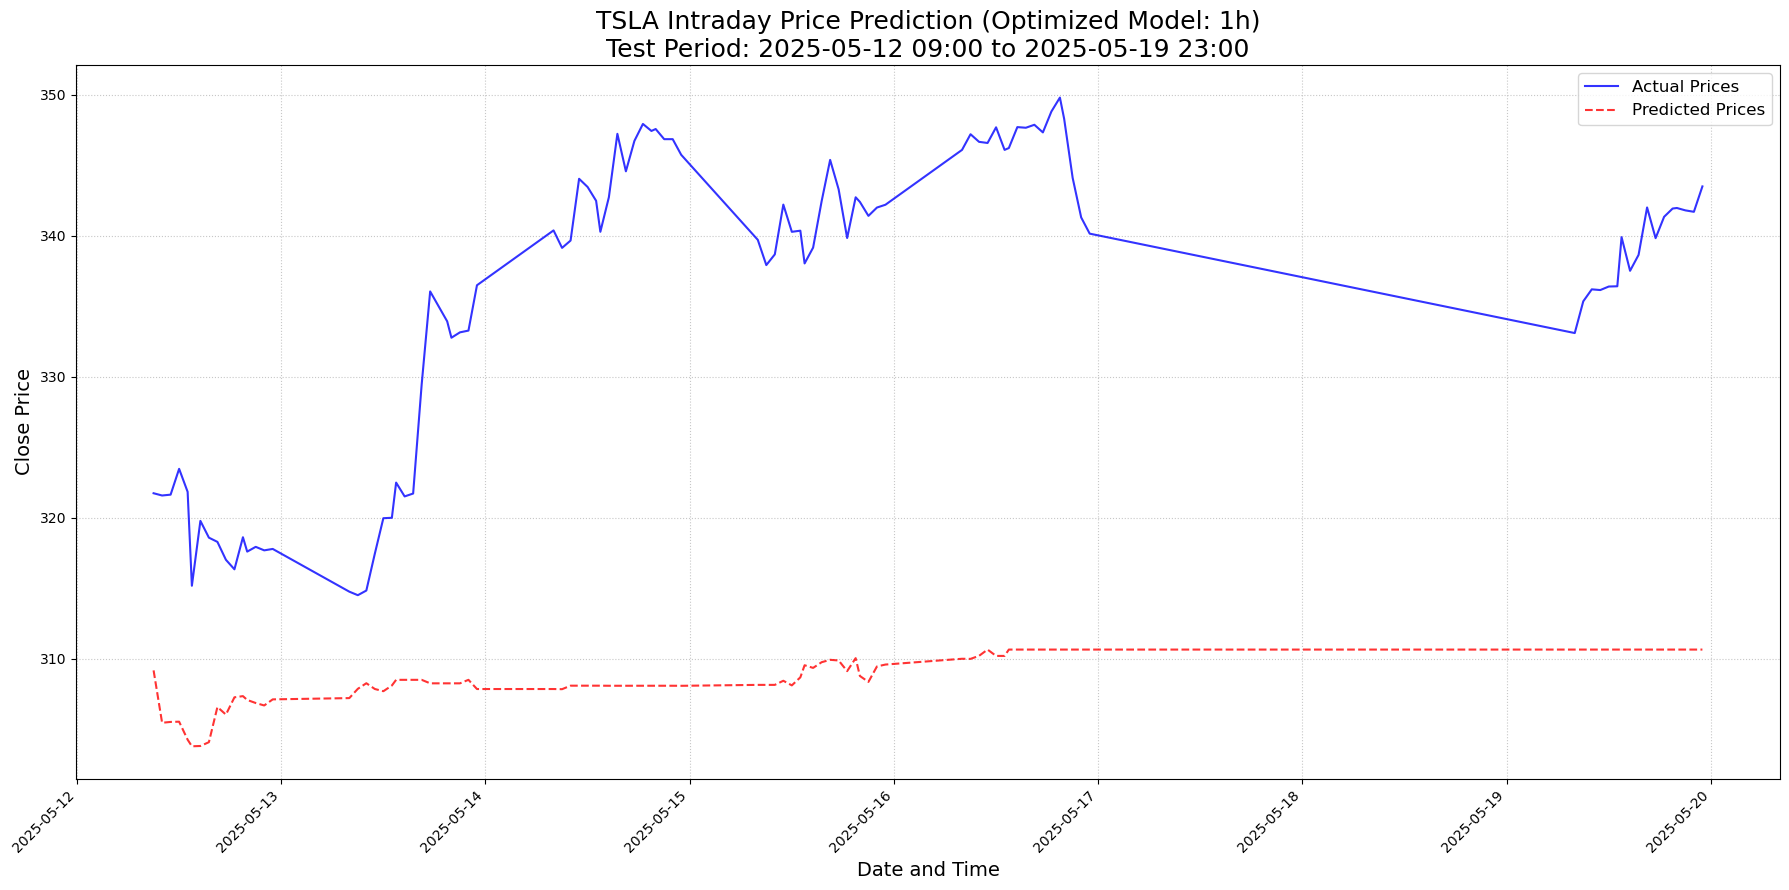

In [146]:
if __name__ == "__main__":
    
    
    # 1. Optimize for 'TSLA' over the last 50 days
    # The start_date and end_date will be dynamically calculated for the last 50 days from the current execution time.
    optimized_results_tsla = optimize_stock_prediction(symbol='TSLA', past_days=50)

    if optimized_results_tsla:
        best_params_tsla = optimized_results_tsla['best_params']
        best_mse_tsla = optimized_results_tsla['best_mse']

        print(f"\n--- Retraining and preparing data for interactive plot using optimized parameters for TSLA ---")
        # Recalculate dates to ensure they are current at the time of execution
        end_date_tsla = datetime.now()
        start_date_tsla = end_date_tsla - timedelta(days=50)
        start_date_str_tsla = start_date_tsla.strftime('%Y-%m-%d')
        end_date_str_tsla = end_date_tsla.strftime('%Y-%m-%d')

        # 2. Call the full analysis function with the best parameters to get plot data for TSLA
        final_mse_tsla, plot_data_tsla = analyze_stock_performance_intraday(
            symbol='TSLA',
            start_date=start_date_str_tsla,
            end_date=end_date_str_tsla,
            interval=best_params_tsla['interval'],
            time_step=best_params_tsla['time_step'],
            n_estimators=best_params_tsla['n_estimators'],
            random_state=42 # Keep random_state consistent for reproducibility
        )

        if plot_data_tsla:
            dates_test_tsla, y_test_tsla, y_pred_tsla = plot_data_tsla

            # 3. Call the new interactive plotting function for TSLA
            plot_intraday_predictions_interactive(
                dates_test=dates_test_tsla,
                y_test=y_test_tsla,
                y_pred=y_pred_tsla,
                symbol='TSLA',
                interval=best_params_tsla['interval'],
                mse=final_mse_tsla,
                plot_title=f'TSLA Intraday Price Prediction (Optimized Model: {best_params_tsla["interval"]})\nTest Period: {dates_test_tsla[0].strftime("%Y-%m-%d %H:%M")} to {dates_test_tsla[-1].strftime("%Y-%m-%d %H:%M")}'
            )
        else:
            print("Failed to get plot data for TSLA after optimization.")
    else:
        print("Optimization for TSLA did not yield any valid results.")


--- Starting optimization for INTU over the last 50 days ---
Total combinations to test: 216
  --> New best MSE: 58.5739 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 54.8222 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 5}
  --> New best MSE: 54.4375 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 5}
  --> New best MSE: 54.2522 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5}
  --> New best MSE: 43.7635 with params: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 43.6406 with params: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 1}
  --> New best MSE: 43.2674 with params: {'interval': '5m', 'time_step': 90, 

[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for INTU ---
Best Parameters: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1}
Lowest Mean Squared Error: 42.5813

--- Retraining and preparing data for interactive plot using optimized parameters for TSLA ---
--- Analyzing INTU (5m interval) from 2025-03-31 to 2025-05-20 ---


Mean Squared Error for INTU (5m): 43.2674

--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


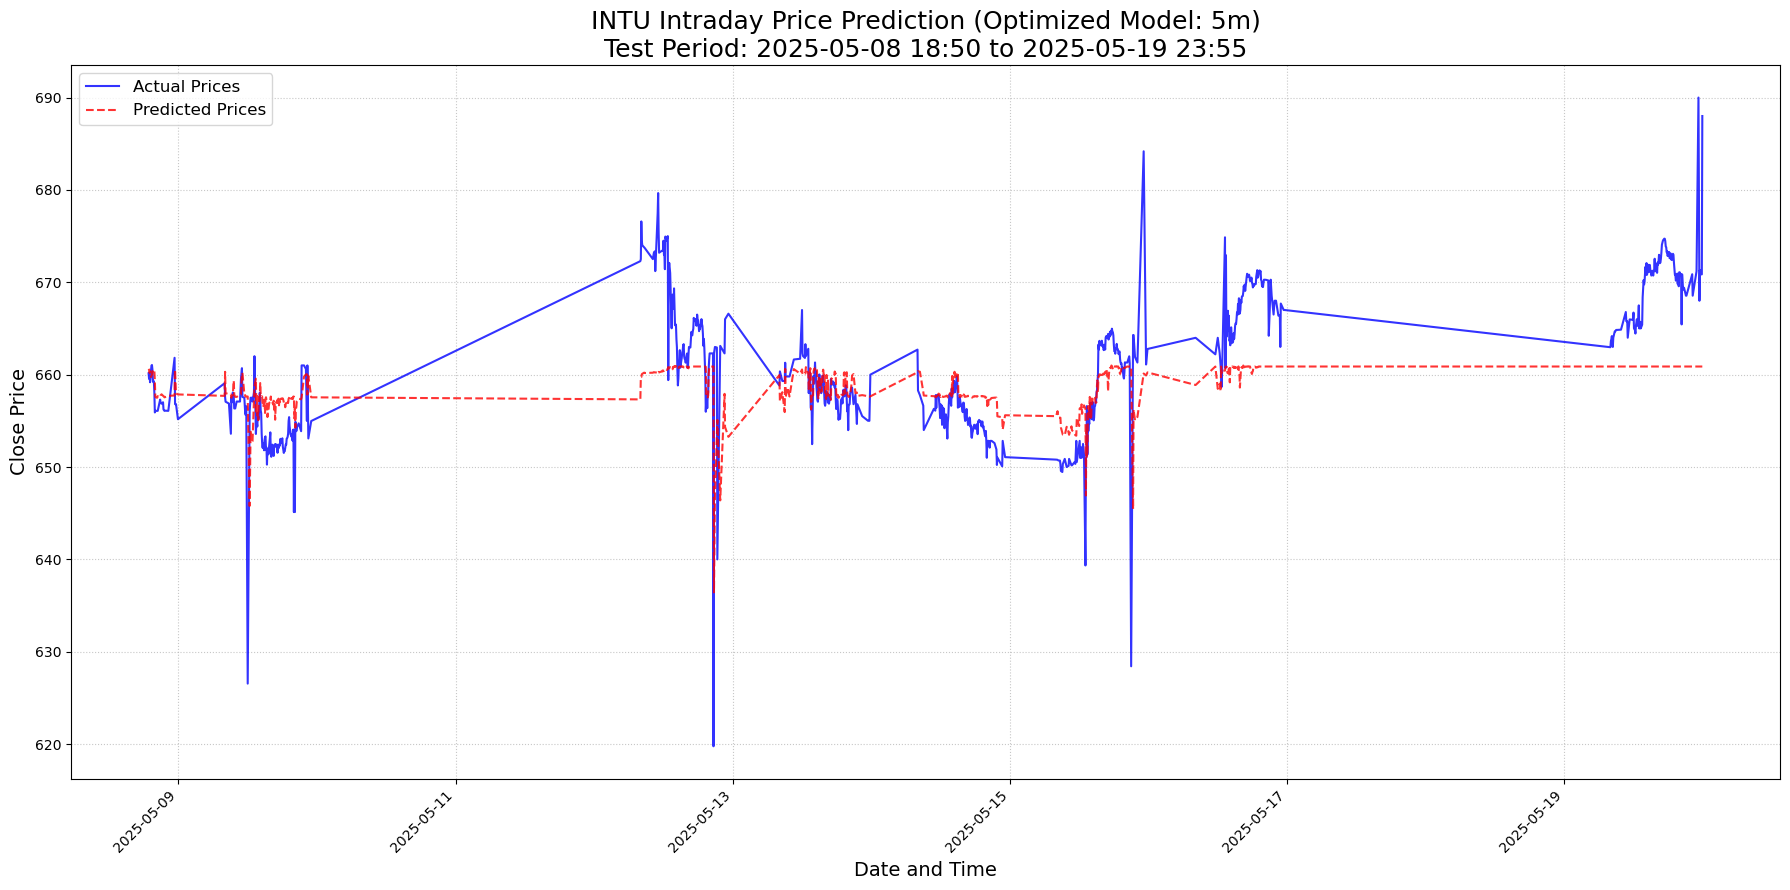

In [147]:
if __name__ == "__main__":
    
    
    # 1. Optimize for 'INTU' over the last 50 days
    # The start_date and end_date will be dynamically calculated for the last 50 days from the current execution time.
    optimized_results_intu = optimize_stock_prediction(symbol='INTU', past_days=50)

    if optimized_results_intu:
        best_params_tsla = optimized_results_intu['best_params']
        best_mse_tsla = optimized_results_intu['best_mse']

        print(f"\n--- Retraining and preparing data for interactive plot using optimized parameters for TSLA ---")
        # Recalculate dates to ensure they are current at the time of execution
        end_date_tsla = datetime.now()
        start_date_tsla = end_date_tsla - timedelta(days=50)
        start_date_str_tsla = start_date_tsla.strftime('%Y-%m-%d')
        end_date_str_tsla = end_date_tsla.strftime('%Y-%m-%d')


        final_mse_tsla, plot_data_tsla = analyze_stock_performance_intraday(
            symbol='INTU',
            start_date=start_date_str_tsla,
            end_date=end_date_str_tsla,
            interval=best_params_tsla['interval'],
            time_step=best_params_tsla['time_step'],
            n_estimators=best_params_tsla['n_estimators'],
            random_state=42 # Keep random_state consistent for reproducibility
        )

        if plot_data_tsla:
            dates_test_tsla, y_test_tsla, y_pred_tsla = plot_data_tsla


            plot_intraday_predictions_interactive(
                dates_test=dates_test_tsla,
                y_test=y_test_tsla,
                y_pred=y_pred_tsla,
                symbol='INTU',
                interval=best_params_tsla['interval'],
                mse=final_mse_tsla,
                plot_title=f'INTU Intraday Price Prediction (Optimized Model: {best_params_tsla["interval"]})\nTest Period: {dates_test_tsla[0].strftime("%Y-%m-%d %H:%M")} to {dates_test_tsla[-1].strftime("%Y-%m-%d %H:%M")}'
            )
        else:
            print("Failed to get plot data for INTU after optimization.")
    else:
        print("Optimization for INTU did not yield any valid results.")


--- Starting optimization for AAPL over the last 50 days ---
Total combinations to test: 216
  --> New best MSE: 0.1714 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
  --> New best MSE: 0.1571 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 5}
  --> New best MSE: 0.1557 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 5}
  --> New best MSE: 0.1536 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 5}
  --> New best MSE: 0.1528 with params: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5}


[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for AAPL ---
Best Parameters: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5}
Lowest Mean Squared Error: 0.1528

--- Retraining and preparing data for interactive plot using optimized parameters for AAPL ---
--- Analyzing AAPL (5m interval) from 2025-03-31 to 2025-05-20 ---


Mean Squared Error for AAPL (5m): 0.1672

--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


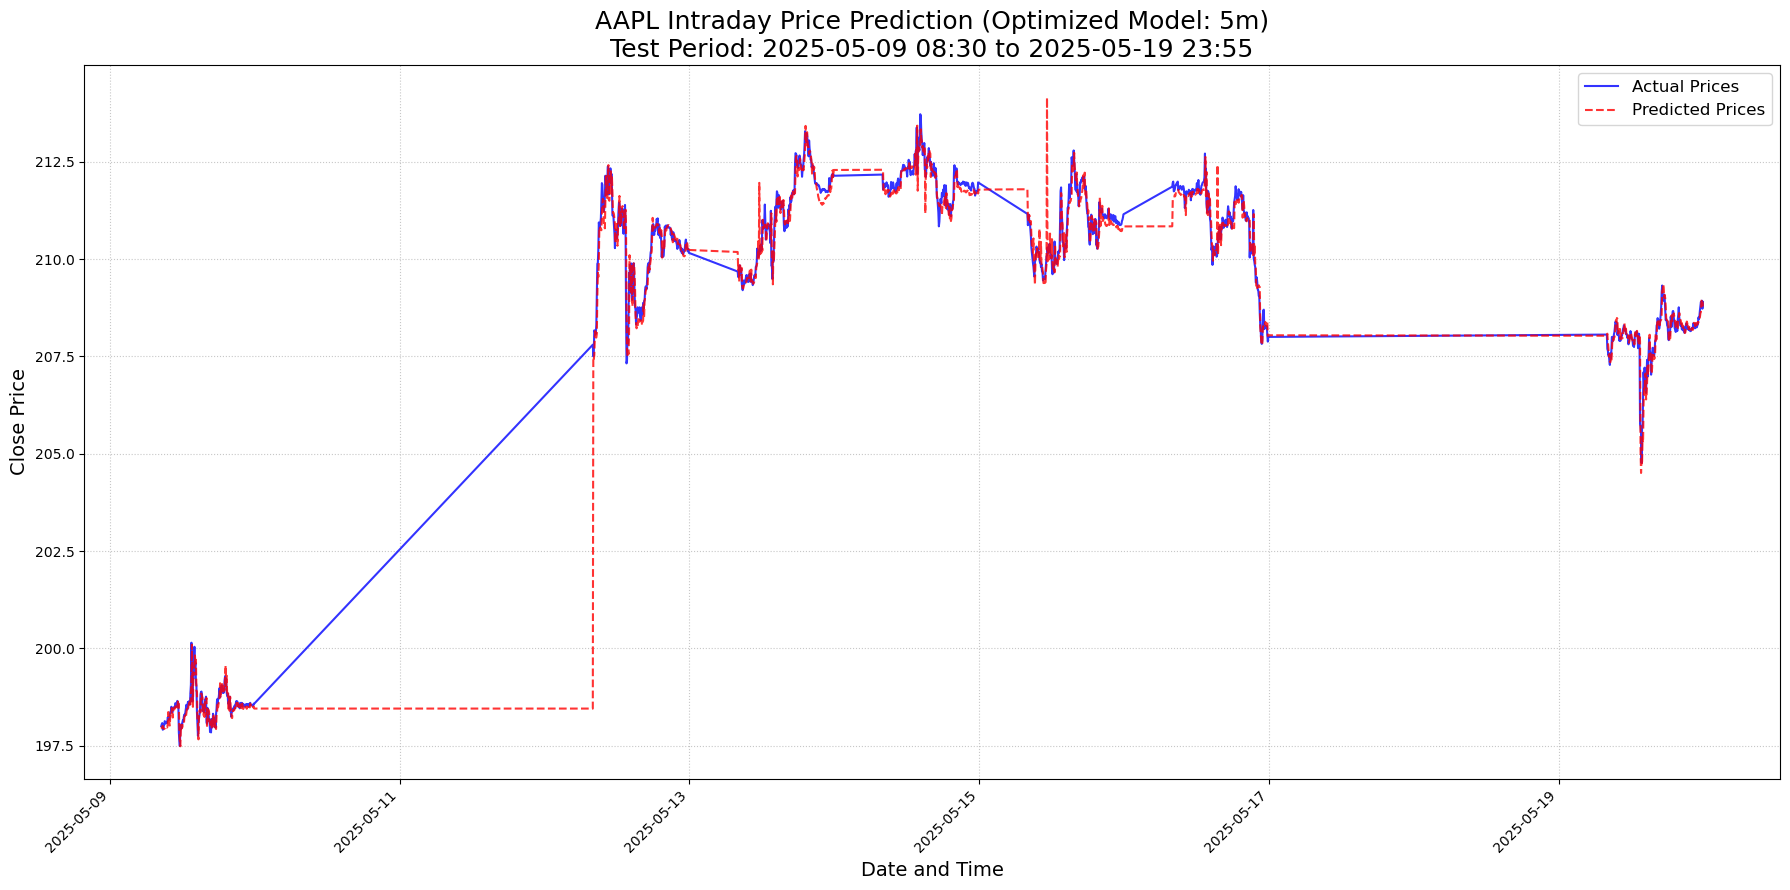

In [148]:
if __name__ == "__main__":
   

    # The start_date and end_date will be dynamically calculated for the last 50 days from the current execution time.
    optimized_results_aapl = optimize_stock_prediction(symbol='AAPL', past_days=50)

    if optimized_results_aapl:
        best_params_tsla = optimized_results_aapl['best_params']
        best_mse_tsla = optimized_results_aapl['best_mse']

        print(f"\n--- Retraining and preparing data for interactive plot using optimized parameters for TSLA ---")
        # Recalculate dates to ensure they are current at the time of execution
        end_date_tsla = datetime.now()
        start_date_tsla = end_date_tsla - timedelta(days=50)
        start_date_str_tsla = start_date_tsla.strftime('%Y-%m-%d')
        end_date_str_tsla = end_date_tsla.strftime('%Y-%m-%d')

        # 2. Call the full analysis function with the best parameters to get plot data for TSLA
        final_mse_tsla, plot_data_tsla = analyze_stock_performance_intraday(
            symbol='AAPL',
            start_date=start_date_str_tsla,
            end_date=end_date_str_tsla,
            interval=best_params_tsla['interval'],
            time_step=best_params_tsla['time_step'],
            n_estimators=best_params_tsla['n_estimators'],
            random_state=42 # Keep random_state consistent for reproducibility
        )

        if plot_data_tsla:
            dates_test_tsla, y_test_tsla, y_pred_tsla = plot_data_tsla

            # 3. Call the new interactive plotting function for TSLA
            plot_intraday_predictions_interactive(
                dates_test=dates_test_tsla,
                y_test=y_test_tsla,
                y_pred=y_pred_tsla,
                symbol='AAPL',
                interval=best_params_tsla['interval'],
                mse=final_mse_tsla,
                plot_title=f'AAPL Intraday Price Prediction (Optimized Model: {best_params_tsla["interval"]})\nTest Period: {dates_test_tsla[0].strftime("%Y-%m-%d %H:%M")} to {dates_test_tsla[-1].strftime("%Y-%m-%d %H:%M")}'
            )
        else:
            print("Failed to get plot data for AAPL after optimization.")
    else:
        print("Optimization for TA did not yield any valid results.")